# Home Credit Default Risk
## Can you predict how capable each applicant is of repaying a loan?

Welcome to my model of the above Kaggle competition. We are given the following problem:

"Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful."


### Goal
Our goal for this project is to create a model that predict a new clients ability to repay a loan. 

### Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

### Data 
We are given multiple connected datasets to work from. They are as follows:
1. application_{train|test}.csv - This is the main dataset we are working off of. It contains the primary keys which connect this table to other more specific tables.
2. bureau.csv
3. bureau_balance.csv
4. POS_CASH_balance.csv
5. credit_card_balance.csv
6. previous_application.csv
7. installments_payments.csv
8. HomeCredit_columns_description.csv

# Exploratory Data Analysis Part I
For this part, we start by only examining the main table, $\texttt{application_train.csv}$.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
sns.set()

import matplotlib.pyplot as plt

In [3]:
application_train = pd.read_csv('application_train.csv')

In [4]:
application_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### Data Types
First, we examine the types of data we have:

In [5]:
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

We have 106 numerical columns and 16 categorical (or ordinal) columns. We need to keep this in mind when we move on the feature engineering. Let's get a list of the following categorical features:

In [6]:
application_train.select_dtypes(include = 'object').columns.to_list()

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

Some of these features we will one-hot encode (such as 'CODE_GENDER' and'OCCUPATION_TYPE') as there is not a clear ordering to their values. However, we will label encode the two flag variables, 'FLAG_OWN_CAR','FLAG_OWN_REALTY' to match the form of the other flags that appear in our data (such as 'FLAG_MOBIL').

### Missing Data
Next, we examine which columns have missing data:

In [7]:
mis_val = application_train.isnull().sum()
        
# Percentage of missing values
mis_val_percent = 100 * application_train.isnull().sum() / len(application_train)
        
# Make a table with the results
mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
missing_values = mis_val_table.rename(
columns = {0 : 'Missing Values', 1 : '% of Total Values'}).sort_values(
        '% of Total Values', ascending=False).round(1)

In [8]:
missing_values.head(30)

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4


In total, there are 67 features with missing entries. For now, we don't drop any of these features. Instead, when it comes to feature engineering, we will decide then.

### Distribution of Target
Let's take a look at the distribution of our target variable. For reference, 0 means that a loan was repayed on time, and 1 means that a loan was either redpaid late, or not repaid at all. Getting information on the distribution will give us insight into our models as balanced class problems need to be treated differently than unbalanced class problems

0.08072881945686496

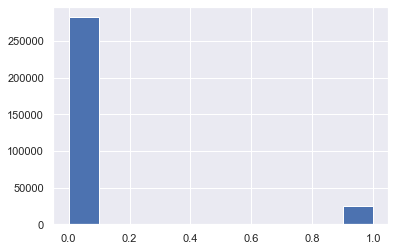

In [9]:
target = application_train['TARGET']
%matplotlib inline
plt.hist(target)

target.mean()

We can clearly see this is a highly imbalanced class problem. The majority of the loans (about 92%) we repaid on time. Given these highly imbalanced classes, classifiction accuracy on its own would be a poor metric. A dummy classifier that always guesses 0 would have a classification accuracy of approximately 92%! 

Given that we are dealing with lending out possibly large amounts of money, we don't want our model to determine that a client will repay a loan if they wont. This is why we are instead using another scoring metric such as AUC. (TALK MORE IN DETAIL ABOUT WHY). 

### Encoding Features
Originally, I had planned on doing this in the feature engineering stage. However, encoding all our categorical and ordinal information now means that we can make sense of their correlation with the target below. In the full model, this will be turned into a step in our pipeline. 

In [10]:
label_enc_features =['FLAG_OWN_CAR','FLAG_OWN_REALTY']
categorical_enc_features = ['NAME_CONTRACT_TYPE','CODE_GENDER','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START','ORGANIZATION_TYPE','FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE']

In [11]:
from sklearn.preprocessing import LabelEncoder

#Label encoding
le = LabelEncoder()
for feature in label_enc_features:
    application_train[feature] = le.fit_transform(application_train[feature])

#Categorical Encoding
application_train = pd.get_dummies(application_train)

This time, we got lucky. If we run the same categorical encoder on the test data, we actually find that there are a few extra categories that appear in the training data that do not appear in the test data (4 extra to be exact). 

We should fix this issue now so we are not training our model on data that it will never see in the test set. To do this, we align the two dataframes.

In [12]:
application_test = pd.read_csv('application_test.csv')
application_test =  pd.get_dummies(application_test)


application_train= application_train.drop('TARGET',axis = 1)

application_train, application_test = application_train.align(application_test, join = 'inner', axis = 1)
application_train['TARGET'] = target

In [13]:
print(application_train.shape)
print(application_test.shape)

(307511, 239)
(48744, 238)


## Outliers
Using the .describe() feature, we take a look at some of the features to determine if there are any outliers. The first feature that stands out is 'DAYS_EMPLOYED': 

In [14]:
job_years = (-1/365)*application_train['DAYS_EMPLOYED']
job_years.describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

That can't be right! According to this, the average customer applying for loans has been working for $-174$ years. In addition, the standard deviation is very large. If we go into the dataset, we see that the value $365243$ appears many times. A cursory glance at other features shows us that this value usually appears for older customers applying. 

In total, $365243$ appears $55374$ times in our training dataset. After looking around a bit, I was able to determine that this is the encoding for these missing values. It is also worth noting that XNA/XAP also denote missing values when they arise. 



## Feature Correlations
We use Pearson's correlation coefficient to examine the correlation between all our main features and the target. However, we just need to be a bit careful when interpereting these results. A feature having a positive correlation with the target means that the customers with these features will be *less* likely to repay the loan. 

In [15]:
correlation_values = application_train.corr()['TARGET'].sort_values()
print("Stronget negative correlations:") 
correlation_values.head(20)

Stronget negative correlations:


EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
DAYS_EMPLOYED                          -0.044932
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
EMERGENCYSTATE_MODE_No                 -0.042201
HOUSETYPE_MODE_block of flats          -0.040594
AMT_GOODS_PRICE                        -0.039645
REGION_POPULATION_RELATIVE             -0.037227
ELEVATORS_AVG                          -0.034199
ELEVATORS_MEDI                         -0.033863
FLOORSMIN_AVG                          -0.033614
FLOORSMIN_MEDI                         -0.033394
WALLSMATERIAL_MODE_Panel               -0.033119
Name: TARGET, dtype:

Ignoring the External features for now, we see that customers with post-secondary education, older customers, and customers that are female are the customers most strongly correlated with repaying a loan on time. 

In [16]:
print("Stronget positive correlations:")
correlation_values.tail(20)

Stronget positive correlations:


NAME_CONTRACT_TYPE_Cash loans                        0.030896
DEF_60_CNT_SOCIAL_CIRCLE                             0.031276
DEF_30_CNT_SOCIAL_CIRCLE                             0.032248
LIVE_CITY_NOT_WORK_CITY                              0.032518
OWN_CAR_AGE                                          0.037612
DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_R

Wait what? According to this, DAYS_BIRTH is strongly correlated with customers not being able to repay their loan. Isn't this contradictory with what we noticed above? Confusingly, the DAYS_BIRTH is actually the negative of the clients age in days. Therefore, this agrees with our above findings. Older customers are more likely to repay their loans, and younger clients are less likely. Similarly, DAYS_LAST_PHONE_CHANGE, DAYS_ID_PUBLISH, and DAYS_REGISTRATION are also given in *negative* days. 

Looking at the other features, we can see that customers that have poorer region ratings, are male, have changed their phone more recently, or work in a different city than they live are less likely to repay their loans on time. 

## Examining Strongest Features in more detail
Let's take a look at some of the stronger features in more detail.

### Client Age

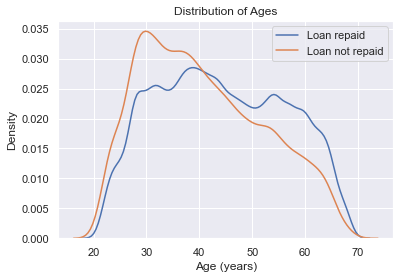

In [17]:
import seaborn as sns
sns.set()
%matplotlib inline
# KDE plot of loans that were repaid on time
sns.kdeplot(-1*application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'Loan repaid')

# KDE plot of loans which were not repaid on time
sns.kdeplot(-1*application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'Loan not repaid')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');


In [18]:
client_ages = (-1/365)*application_train['DAYS_BIRTH']
client_ages.describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

### External Sources
To a certain extent, these are black-boxed features given to us. We can think of these as some feature engineering already done for us. 

In [19]:
ext_sources = application_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
ext_sources.describe()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
count,134133.000000,3.068510e+05,246546.000000
mean,0.502130,5.143927e-01,0.510853
std,0.211062,1.910602e-01,0.194844
min,0.014568,8.173617e-08,0.000527
25%,0.334007,3.924574e-01,0.370650
50%,0.505998,5.659614e-01,0.535276
75%,0.675053,6.636171e-01,0.669057
max,0.962693,8.549997e-01,0.896010


No information about these scores is given to us, but we can make some estimates by examining features that are correlated with the scores. Let's take the following features and examine their correlations with the sources. 

In [20]:
features = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH','DAYS_EMPLOYED','CODE_GENDER_M','CODE_GENDER_F','DAYS_REGISTRATION']
selected_features = application_train[features]
ext_corrs = selected_features.corr()

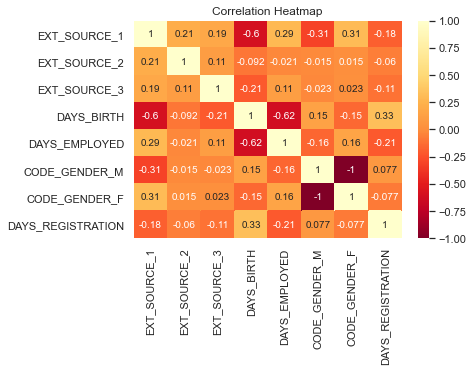

In [21]:
%matplotlib inline
sns.heatmap(ext_corrs, cmap = plt.cm.YlOrRd_r, vmin = -1, annot = True, vmax = 1)
plt.title('Correlation Heatmap');

We just picked a few of the features we found above. From this correlation heatmap, we can see the following: 
1. DAYS_BIRTH is fairly negatively corellated with the first External Source score meaning as clients get older, this score increases.
2. DAYS_EMPLOYED is positively correlated with the first External Source score. 
3. Their are gender correlations between the first External Source score. 

These patterns are also shared with the third External Source score (albeit with much lower correlation values). We can hypothesize that these external scores are somewhat based on a combination of these factors in combination with others.

Something worth noting is that all three external sources are not that highly correlated with each other. This is good for us as it means we can use all three features in our model without worrying about cross-correlation!

Another interesting feature we have is WEEKDAY_APPR_PROCESS_START, the day of the week the client asked to start a previous application. 

## ADD MORE PAIR PLOTS!!!


# Imputing Missing/Inf Values
As we noted above, the numerical value, $365243$ and the label XNA/XAP are used to denote missing values when they occur. In addition to this, we produced the above table listing all features that were missing values. 